In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def add(a, b):
    return a + b
result = add(5, '3')

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
!pip install numpy==1.23.5 mediapipe==0.10.21

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 875.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
import cv2
import os
from IPython.display import display, HTML, clear_output
import base64
import numpy as np
from google.colab import output
import json
import asyncio
import time
import nest_asyncio
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [ ]:
#@title Реализация на JavaScript внешней калибровки - ДЛЯ ТЕСТИРОВАНИЯ....
# Глобальная переменная для хранения изображений
image_buffer = []

# Функция для отображения всех накопленных изображений
def display_all_images():
    for img in image_buffer:
        plt.figure(figsize=(16, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


nest_asyncio.apply()  # Применяем patch для вложения циклов событий

# Асинхронная функция для завершения отметки точек
async def get_coords(timeout=120):
    """
    Функция для получения координат точек с таймаутом.
    """
    start_time = time.time()
    while True:
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout:
            print("Время ожидания истекло. Прерывание процесса...")
            return None

        json_coords = output.eval_js('window.colab_coords || null')
        if json_coords is not None:
            coords = np.array(json.loads(json_coords))  # Преобразуем JSON в массив NumPy
            clear_output()
            print(f"Отмечено {len(coords)} точек на изображении.")
            print(coords)
            return coords
        await asyncio.sleep(0.1)  # Асинхронное ожидание

# Обертка для вызова асинхронной функции
def run_get_coords():
    import asyncio
    loop = asyncio.get_event_loop()  # Получаем текущий event loop
    try:
        return loop.run_until_complete(get_coords())  # Выполняем асинхронную задачу
    except KeyboardInterrupt:
        print("Прервано пользователем.")
        return None

# Функция для отображения изображения и получения координат
def imgp_objp_visualizer_clicker_js(img):
    """
    Функция для получения координат точек на изображении с использованием canvas и JavaScript.
    """
    # Конвертируем изображение в формат base64 для отображения в HTML
    _, img_encoded = cv2.imencode('.jpg', img)
    img_base64 = base64.b64encode(img_encoded).decode('utf-8')

    # Создаем HTML-код с canvas
    display(HTML(f'''
        <h3>Кликните на изображении для отметки точек.</h3>
        <canvas id="canvas" style="border:1px solid #000000;"></canvas>
        <button id="finishButton">Finish</button>  <!-- Кнопка всегда активна -->
        <p>Отмеченные точки:</p>
        <ul id="coordsList"></ul>
        <script>
            // Глобальные переменные
            var coords = [];
            var finishButton = document.getElementById('finishButton');
            var coordsList = document.getElementById('coordsList');

            // Создаем холст и загружаем изображение
            var img = new Image();
            img.src = 'data:image/jpeg;base64,{img_base64}';
            img.onload = function() {{
                var canvas = document.getElementById('canvas');
                canvas.width = img.width;
                canvas.height = img.height;
                var ctx = canvas.getContext('2d');
                ctx.drawImage(img, 0, 0);

                // Обработка кликов
                canvas.onclick = function(event) {{
                    var rect = canvas.getBoundingClientRect();
                    var x = event.clientX - rect.left;
                    var y = event.clientY - rect.top;

                    // Сохраняем координаты
                    coords.push([x, y]);
                    google.colab.kernel.invokeFunction('notebook.handle_click', [x, y], {{}});

                    // Отмечаем точку красным кругом
                    ctx.beginPath();
                    ctx.arc(x, y, 5, 0, 2 * Math.PI);
                    ctx.fillStyle = 'blue';
                    ctx.fill();

                    // Обновляем список координат
                    var li = document.createElement('li');
                    li.textContent = '(' + x + ', ' + y + ')';
                    coordsList.appendChild(li);
                }};

                // Кнопка завершения
                finishButton.addEventListener('click', function() {{
                    if (coords.length === 0) {{
                        alert("Необходимо отметить хотя бы одну точку!");
                        return;
                    }}
                    console.log("Кнопка 'Finish' нажата. Отправка координат:", coords);
                    window.colab_coords = JSON.stringify(coords);  // Сохраняем координаты в глобальную переменную
                }});
            }};
        </script>
    '''))

    # Возвращаем функцию для получения координат
    return run_get_coords

# Функция для сохранения калибровочных данных в YAML
def save_calibration_to_yaml(calib_dir, cam_name, reprojection_error, R, T, file_name=None):
    """
    Сохраняет калибровочные данные (включая внешние параметры) для конкретной камеры в YAML-файл.

    :param calib_dir: Директория для сохранения файла.
    :param cam_name: Имя камеры.
    :param reprojection_error: Ошибка повторной проекции.
    :param file_name: Необязательное имя файла (если None, используется стандартное имя).
    """
    if file_name is None:
        file_name = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam_name}_extrinsics.yaml')

    # Создаем объект FileStorage для записи данных
    cv_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)

    # Записываем данные
    cv_file.write("camera_name", cam_name)
    cv_file.write("reprojection_error", reprojection_error)
    cv_file.write("rotation_matrix", R)
    cv_file.write("translation_vector", T)

    # Закрываем файл
    cv_file.release()

    print(f"Калибровочные данные для камеры {cam_name} успешно сохранены в {file_name}")

# Функция для чтения внутренних параметров камеры из YAML
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')

    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    else:  print(f"Файл внутренних параметров {yaml_file} найден.")
    print (yaml_file)
    cv_file = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)

    if cv_file.isOpened():
        # Читаем данные
        ret = cv_file.getNode("reprojection_error").real()  # Средняя ошибка повторной проекции

        K = cv_file.getNode("camera_matrix").mat()  # Средняя ошибка повторной проекции
        D = cv_file.getNode("distortion_coefficients").mat()  # Матрица внутренних параметров

        print (K, D)
        #fs.release()
        return K, D
    else:
        print(f"Ошибка при открытии файла {yaml_file}.")
        return None, None

# Основная функция для калибровки внешних параметров
def calibrate_extrinsics(calib_dir, extrinsics_config_dict):
    try:
        extrinsics_cam_listdirs_names = next(os.walk(os.path.join(calib_dir, 'extrinsics')))[1]
        print (extrinsics_cam_listdirs_names)
    except StopIteration:
        print(f"Ошибка: Папка {os.path.join(calib_dir, 'extrinsics')} не найдена.")
        return [], [], []

    extrinsics_method = extrinsics_config_dict.get('extrinsics_method')
    if extrinsics_method != 'scene':
        print('Ошибка: В данном примере поддерживается только метод "scene".')
        return [], [], []

    object_coords_3d = np.array(extrinsics_config_dict['scene']['object_coords_3d'], np.float32)
    extrinsics_extension = extrinsics_config_dict['scene']['extrinsics_extension']
    show_reprojection_error = extrinsics_config_dict['scene']['show_reprojection_error']

    # Количество точек 3D
    pcs_points = len(object_coords_3d)

    R, T, reprojection_errors = [], [], []  # Список для хранения ошибок повторной проекции

    for i, cam in enumerate(extrinsics_cam_listdirs_names):
        print(f'\nОбработка камеры {cam}:')

        # Загрузка внутренних параметров камеры
        K, D = load_intrinsics_opencv(calib_dir, cam)
        if K is None or D is None:
            print(f"Пропуск камеры {cam} из-за отсутствия или некорректных внутренних параметров.")
            continue

        # Читаем первое изображение для камеры
        img_files = sorted([
            f for f in os.listdir(os.path.join(calib_dir, 'extrinsics', cam))
            if f.endswith(extrinsics_extension)
        ])
        if not img_files:
            print(f"Для камеры {cam} не найдено изображений. Пропуск...")
            continue

        img_path = os.path.join(calib_dir, 'extrinsics', cam, img_files[0])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {img_path}. Пропуск...")
            continue
        print(f"Использование изображения: {img_path}")

        # Отображение графика расположения точек object_coords_3d
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            object_coords_3d[:, 0],  # Координата X
            object_coords_3d[:, 1],  # Координата Y
            object_coords_3d[:, 2],  # Координата Z
            c='r', marker='o'
        )

        # Добавление нумерации точек
        for j, point in enumerate(object_coords_3d):
            ax.text(point[0], point[1], point[2], str(j), color="blue", fontsize=10)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Расположение точек object_coords_3d')
        plt.show()

        # Нахождение углов вручную (используем JavaScript-версию)
        get_coords_func = imgp_objp_visualizer_clicker_js(img)

        # Ожидаем результатов от JavaScript
        coords = get_coords_func()
        print(coords)

        if len(coords) < pcs_points:
            print(f'Для калибровки необходимо отметить {pcs_points} точек. Пропуск...')
            continue

        # Преобразуем координаты в формат NumPy
        imgp = np.array(coords, dtype=np.float32)
        objp = object_coords_3d

        # Вычисление внешних параметров
        try:
            _, rvec, tvec = cv2.solvePnP(objp, imgp, K, D)
            R_mat = cv2.Rodrigues(rvec)[0]  # Преобразование Rodrigues в матрицу поворота
            T_vec = tvec.flatten()

            R.append(R_mat)
            T.append(T_vec)

            # Проверка результатов калибровки
            if show_reprojection_error:
                proj_points, _ = cv2.projectPoints(objp, rvec, tvec, K, D)

                # Создаем копию изображения для отображения точек
                img_with_points = img.copy()

                # Рисуем предсказанные точки (зеленый цвет)
                proj_points = proj_points.squeeze().astype(np.int32)
                for point in proj_points:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 255, 0), -1)  # Зеленые круги

                # Рисуем отмеченные точки (красный цвет)
                imgp_int = imgp.astype(np.int32)
                for point in imgp_int:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 0, 255), -1)  # Красные круги

                # Сохраняем изображение в буфер
                image_buffer.append(img_with_points)
                print(f"Проекция и отмеченные точки для камеры {cam} успешно нанесены на изображение.")

                # Вычисляем ошибку повторной проекции
                reprojection_error = np.mean(np.linalg.norm(imgp.squeeze() - proj_points, axis=1))
                reprojection_errors.append(reprojection_error)  # Добавляем ошибку в список
                print(f"Ошибка повторной проекции для камеры {cam}: {reprojection_error:.4f} пикселей")

                # Сохраняем параметры калибровки в YAML
                save_calibration_to_yaml(calib_dir, cam, reprojection_error, R_mat, T_vec)

            else:
                reprojection_errors.append(None)  # Если не показываем ошибку, добавляем None

            print(f"Внешние параметры для камеры {cam} успешно вычислены.")

        except Exception as e:
            print(f"Ошибка при вычислении внешних параметров для камеры {cam}: {e}")
            reprojection_errors.append(None)  # В случае ошибки добавляем None

    # Отображаем все сохраненные изображения
    display_all_images()

    return R, T, reprojection_errors

Отмечено 9 точек на изображении.
[[ 880.        279.828125]
 [ 570.        333.828125]
 [1379.        288.828125]
 [1120.        345.828125]
 [ 784.        425.828125]
 [ 301.        536.828125]
 [1722.        356.828125]
 [1479.        440.828125]
 [1117.        564.828125]]
[[ 880.        279.828125]
 [ 570.        333.828125]
 [1379.        288.828125]
 [1120.        345.828125]
 [ 784.        425.828125]
 [ 301.        536.828125]
 [1722.        356.828125]
 [1479.        440.828125]
 [1117.        564.828125]]
Проекция и отмеченные точки для камеры cam4 успешно нанесены на изображение.
Ошибка повторной проекции для камеры cam4: 13.8334 пикселей
Калибровочные данные для камеры cam4 успешно сохранены в /content/drive/MyDrive/Karate_2/old_video/extrinsics/calibration_cam4_extrinsics.yaml
Внешние параметры для камеры cam4 успешно вычислены.


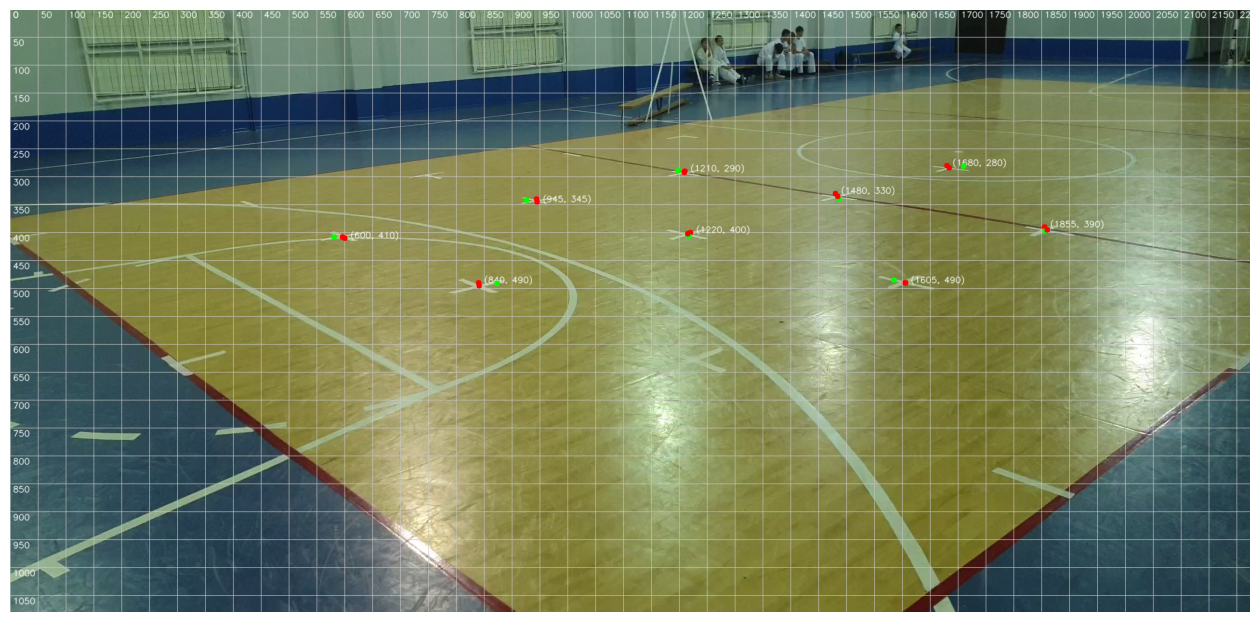

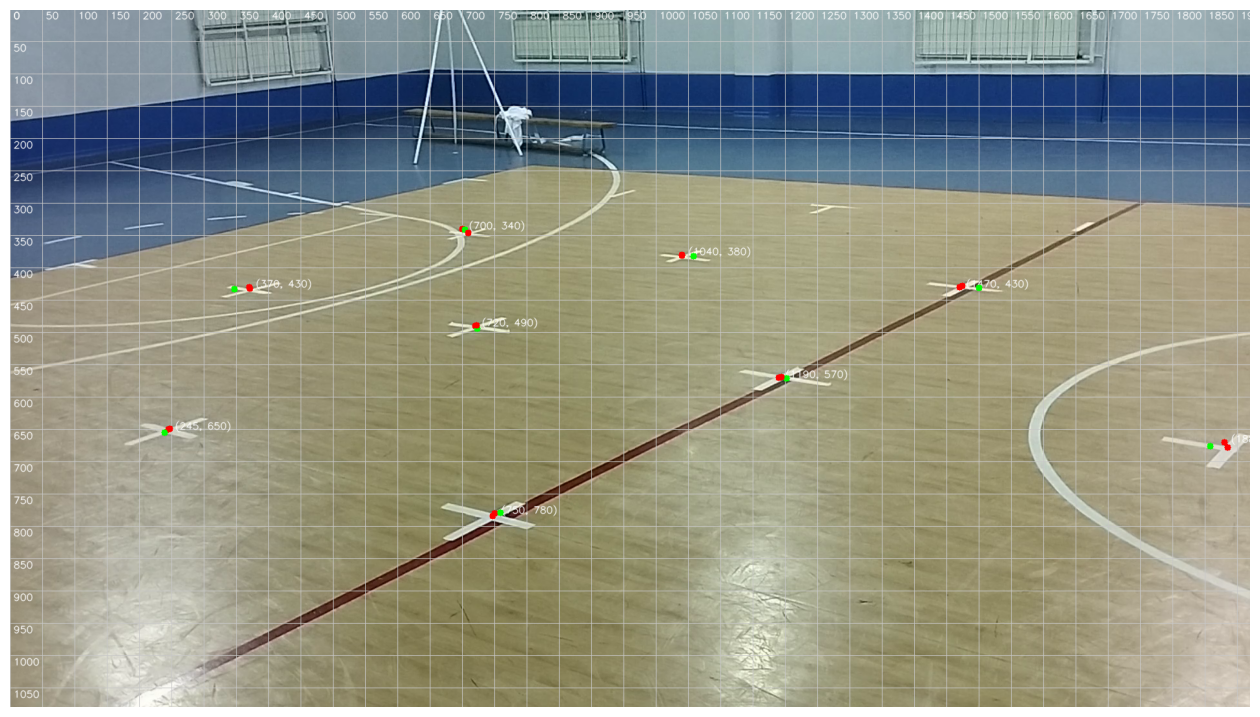

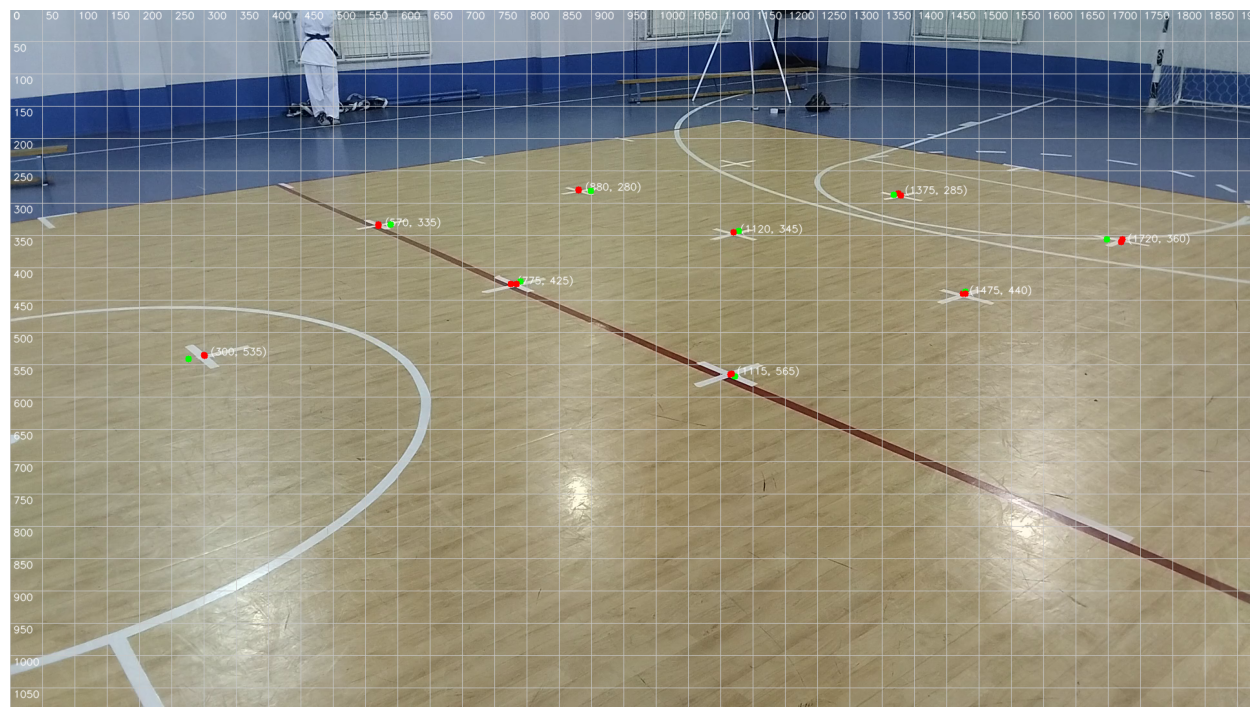

Внешние параметры успешно рассчитаны:

Камера 1:
Матрица поворота:
 [[ 0.65264398 -0.75757903  0.01139513]
 [-0.19925035 -0.18612305 -0.96211097]
 [ 0.73099598  0.62564545 -0.27241997]]
Вектор перемещения:
 [-0.22688983  0.30789625  8.6751625 ]
Ошибка повторной проекции для камеры: 15.3236 пикселей

Камера 2:
Матрица поворота:
 [[ 0.81451037  0.57879368 -0.03963262]
 [ 0.13007729 -0.24877293 -0.95978744]
 [-0.56537842  0.77660151 -0.27791604]]
Вектор перемещения:
 [-4.05633729  0.04911214  8.43966487]
Ошибка повторной проекции для камеры: 15.3452 пикселей

Камера 3:
Матрица поворота:
 [[-0.77412899  0.63297402 -0.00825765]
 [ 0.25605695  0.3011752  -0.91854686]
 [-0.57892931 -0.71318818 -0.39522585]]
Вектор перемещения:
 [ 0.97492377 -2.16553528  9.38994956]
Ошибка повторной проекции для камеры: 13.8334 пикселей


In [ ]:
# Запуск калибровки - перебор калибровки

# Настройки
calib_dir = '/content/drive/MyDrive/Karate_2/old_video'

# Конфигурация для метода scene
extrinsics_config_dict = {
    'extrinsics_method': 'scene',
    'scene': {
        'object_coords_3d': [
            [2, 0, 0], [4, 0, 0],
            [0, 2, 0], [2, 2, 0], [4, 2, 0], [6, 2, 0],
            [0, 4, 0], [2, 4, 0], [4, 4, 0]
        ],  # Задайте координаты объектов в метрах
        'extrinsics_extension': 'png',  # Расширение файлов с изображениями
        'show_reprojection_error': True  # Показывать ли ошибку повторной проекции
    }
}

# Подсчет количества 3D точек
pcs_points = len(extrinsics_config_dict['scene']['object_coords_3d'])

# Вывод результата
print(f"Количество отмеченных 3D точек: {pcs_points}")

# Запуск калибровки
print("Начало процесса калибровки внешних параметров...")
R, T, reprojection_errors = calibrate_extrinsics(calib_dir, extrinsics_config_dict)

if R and T and reprojection_errors:
    print("Внешние параметры успешно рассчитаны:")
    for i, (r, t, re) in enumerate(zip(R, T, reprojection_errors)):
        print(f"\nКамера {i+1}:")
        print("Матрица поворота:\n", r)
        print("Вектор перемещения:\n", t)
        if re is not None:
            print(f"Ошибка повторной проекции для камеры: {re:.4f} пикселей")
        else:
            print("Ошибка повторной проекции не рассчитана.")
else:
    print("Не удалось рассчитать корректные внешние параметры.")

In [ ]:
#@title !!!!Отображаем рамку и ID-персоны - С 0 кадра - отображение номера кадра !!!Создание видео и координат! с позами с учетом приведения к одной частоте и нумерацией с начала видео
import subprocess
from pathlib import Path
import cv2
import pandas as pd
from tqdm import tqdm
import mediapipe as mp
from ultralytics import YOLO  # Используем YOLO для распознавания объектов
import logging
from ultralytics import YOLO

# Отключаем логи YOLO
logging.getLogger("ultralytics").setLevel(logging.WARNING)

# Инициализация YOLO и MediaPipe Pose
yolo_model = YOLO("yolov8n.pt")  # Загружаем предобученную модель YOLO
yolo_model.verbose = False  # Дополнительно отключаем verbose режим

# Функция для обрезки и изменения FPS с отображением прогресса
def trim_and_change_fps(input_path, output_path, start_time, end_time, target_fps=30):
    duration = end_time - start_time
    command = [
        "ffmpeg",
        "-y",
        "-i", str(input_path),
        "-ss", str(start_time),
        "-t", str(duration),
        "-filter:v", f"fps={target_fps}",
        "-c:a", "copy",
        str(output_path)
    ]

    # Запускаем процесс FFmpeg и отслеживаем прогресс
    process = subprocess.Popen(
        command,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )

    # Создаем прогресс-бар
    total_frames = None
    with tqdm(desc=f"Обработка {Path(output_path).name}", unit="frame") as pbar:
        for line in process.stderr:
            if "frame=" in line:
                try:
                    # Извлекаем текущее количество обработанных кадров
                    current_frame = int(line.split("frame=")[1].split()[0])
                    if total_frames is None:
                        # Пытаемся извлечь общее количество кадров (если доступно)
                        total_frames = int(line.split("total=")[1].split()[0]) if "total=" in line else None
                    pbar.total = total_frames or current_frame
                    pbar.update(current_frame - pbar.n)
                except Exception:
                    pass  # Пропускаем строки, которые не удается распарсить
        process.wait()  # Ждем завершения процесса

    # Проверяем, что выходной файл существует и не пуст
    if not Path(output_path).exists() or Path(output_path).stat().st_size == 0:
        raise ValueError(f"FFmpeg не удалось обработать видео. Выходной файл пуст или отсутствует: {output_path}")

# Инициализация YOLO и MediaPipe Pose
yolo_model = YOLO("yolov8n.pt")  # Загружаем предобученную модель YOLO
yolo_model.verbose = False  # Отключаем вывод логов YOLO в консоль

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils  # Для рисования скелета

# Временная директория для преобразованных видео
temp_dir = Path('/content/temp_resampled_videos')
temp_dir.mkdir(parents=True, exist_ok=True)

# Список видео
video_1 = '/content/drive/MyDrive/Karate_2/old_video/cam1.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/old_video/cam3.mp4'
video_4 = '/content/drive/MyDrive/Karate_2/old_video/cam4.mp4'
video_list = [video_1, video_3, video_4]

# Время начала и конца в секундах для каждого видео
time_intervals = {
    'cam1.mp4': (0, 59),
    'cam3.mp4': (0, 59),
    'cam4.mp4': (0, 59),
}

# Преобразуем видео: обрезаем до временных рамок и меняем FPS
resampled_videos = []
for video_path in video_list:
    video_name = Path(video_path).name
    resampled_video_path = temp_dir / video_name

    # Проверка на существование видео в папке
    if resampled_video_path.exists() and resampled_video_path.stat().st_size > 0:
        print(f"Видео {video_name} уже существует в папке {temp_dir}. Пропускаем этап обрезки и изменения FPS.")
        resampled_videos.append(resampled_video_path)
        continue

    # Если видео не существует, выполняем обрезку и изменение FPS
    start_time, end_time = time_intervals[video_name]
    trim_and_change_fps(video_path, resampled_video_path, start_time, end_time, target_fps=30)
    resampled_videos.append(resampled_video_path)


import cv2
from tqdm import tqdm
import pandas as pd
from pathlib import Path

# Функция для обработки видео с использованием YOLO и MediaPipe
def process_video_with_yolo_and_mediapipe(video_path, start_time, fps, output_video_path):
    # Загружаем модель YOLO
    model = YOLO("yolov8n.pt")

    # Открываем видео
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    # Получаем разрешение видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Создаем VideoWriter для сохранения видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для MP4
    out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

    # Вычисляем смещение для номера кадра
    frame_offset = int(start_time * fps)

    # Список для хранения данных о координатах точек позы
    pose_data = []

    # Создаем прогресс-бар
    with tqdm(total=total_frames, desc=f"Обработка {Path(video_path).name}") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Шаг 1: Трекинг объектов с помощью YOLO
            results = model.track(frame, conf=0.5, iou=0.4, persist=True)  # Включаем трекинг

            # Шаг 2: Обработка результатов трекинга
            if results[0].boxes.id is not None:  # Проверяем, есть ли ID треков
                boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box
                ids = results[0].boxes.id.cpu().numpy().astype(int)  # ID треков

                # Рисуем рамки и ID на кадре
                for box, id in zip(boxes, ids):
                    x1, y1, x2, y2 = map(int, box)
                    # Рисуем рамку
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    # Отображаем ID
                    cv2.putText(frame, f"ID: {id}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

            # Шаг 3: Анализ позы с помощью MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(rgb_frame)

            # Рисуем скелет на исходном кадре и сохраняем координаты точек
            frame_pose_data = {'frame_number': frame_count + frame_offset}
            if pose_results.pose_landmarks:
                # Корректируем координаты ключевых точек
                adjusted_landmarks = []
                for i, landmark in enumerate(pose_results.pose_landmarks.landmark):
                    adjusted_x = int(landmark.x * frame_width)
                    adjusted_y = int(landmark.y * frame_height)
                    adjusted_landmarks.append((adjusted_x, adjusted_y))

                    # Сохраняем координаты точек в словарь
                    frame_pose_data[f'x_{i}'] = adjusted_x
                    frame_pose_data[f'y_{i}'] = adjusted_y
                    frame_pose_data[f'visibility_{i}'] = landmark.visibility

                # Отрисовываем скорректированные ключевые точки и связи между ними
                for connection in mp_pose.POSE_CONNECTIONS:
                    start_idx, end_idx = connection
                    start_point = adjusted_landmarks[start_idx]
                    end_point = adjusted_landmarks[end_idx]
                    if all(start_point) and all(end_point):  # Проверяем, что точки существуют
                        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

                for point in adjusted_landmarks:
                    if all(point):  # Проверяем, что точка существует
                        cv2.circle(frame, point, 4, (0, 255, 0), -1)
            else:
                # Если поза не найдена, записываем None для всех точек
                for i in range(33):  # MediaPipe Pose имеет 33 ключевых точки
                    frame_pose_data[f'x_{i}'] = None
                    frame_pose_data[f'y_{i}'] = None
                    frame_pose_data[f'visibility_{i}'] = None

            # Добавляем данные о текущем кадре в общий список
            pose_data.append(frame_pose_data)

            # Отображаем номер кадра на видео
            cv2.putText(frame, f"Frame: {frame_count + frame_offset}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Сохраняем кадр в выходное видео
            out.write(frame)
            frame_count += 1
            pbar.update(1)

    cap.release()
    out.release()

    # Возвращаем данные о координатах точек позы
    return pd.DataFrame(pose_data)


# Директория для сохранения видео с позами
output_video_dir = Path('/content/output_videos_with_poses')
output_video_dir.mkdir(parents=True, exist_ok=True)

# Директория для сохранения CSV файлов с координатами
output_csv_dir = Path('/content/output_csv_pose_data')
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Обработка всех видео
for video_path in resampled_videos:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    fps = 30

    # Путь для сохранения видео с позами
    output_video_path = output_video_dir / f'{video_name}_with_poses.mp4'

    # Обработка видео и сохранение результата
    pose_df = process_video_with_yolo_and_mediapipe(video_path, start_time, fps, output_video_path)
    print(f"Video with poses saved to {output_video_path}")

    # Сохранение данных о координатах точек позы в CSV
    csv_output_path = output_csv_dir / f'{video_name}_pose_data.csv'
    pose_df.to_csv(csv_output_path, index=False)
    print(f"Pose data saved to {csv_output_path}")

# Директория для сохранения видео с позами
output_video_dir = Path('/content/output_videos_with_poses')
output_video_dir.mkdir(parents=True, exist_ok=True)

# Обработка всех видео
for video_path in resampled_videos:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    fps = 30

    # Путь для сохранения видео с позами
    output_video_path = output_video_dir / f'{video_name}_with_poses.mp4'

    # Обработка видео и сохранение результата
    process_video_with_yolo_and_mediapipe(video_path, start_time, fps, output_video_path)
    print(f"Video with poses saved to {output_video_path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 49.9MB/s]
Обработка cam1.mp4: 100%|██████████| 1770/1770 [06:47<00:00,  4.34it/s]


Video with poses saved to /content/output_videos_with_poses/cam1.mp4_with_poses.mp4
Pose data saved to /content/output_csv_pose_data/cam1.mp4_pose_data.csv


Обработка cam3.mp4: 100%|██████████| 1770/1770 [07:01<00:00,  4.19it/s]


Video with poses saved to /content/output_videos_with_poses/cam3.mp4_with_poses.mp4
Pose data saved to /content/output_csv_pose_data/cam3.mp4_pose_data.csv


Обработка cam4.mp4: 100%|██████████| 1770/1770 [06:55<00:00,  4.26it/s]


Video with poses saved to /content/output_videos_with_poses/cam4.mp4_with_poses.mp4
Pose data saved to /content/output_csv_pose_data/cam4.mp4_pose_data.csv


Обработка cam1.mp4: 100%|██████████| 1770/1770 [06:41<00:00,  4.41it/s]


Video with poses saved to /content/output_videos_with_poses/cam1.mp4_with_poses.mp4


Обработка cam3.mp4: 100%|██████████| 1770/1770 [07:16<00:00,  4.05it/s]


Video with poses saved to /content/output_videos_with_poses/cam3.mp4_with_poses.mp4


Обработка cam4.mp4: 100%|██████████| 1770/1770 [06:50<00:00,  4.32it/s]

Video with poses saved to /content/output_videos_with_poses/cam4.mp4_with_poses.mp4


In [ ]:
import pandas as pd
# Пути к файлам
csv_file1 = "/content/output_csv_pose_data/cam1.mp4_pose_data.csv"
csv_file3 = "/content/output_csv_pose_data/cam3.mp4_pose_data.csv"
csv_file4 = "/content/output_csv_pose_data/cam4.mp4_pose_data.csv"

# Загрузка данных
df1 = pd.read_csv(csv_file1)
df3 = pd.read_csv(csv_file4)
df4 = pd.read_csv(csv_file3)

In [ ]:
df4

frame_number    x_0   y_0  visibility_0    x_1   y_1  visibility_1  \
0                0    NaN   NaN           NaN    NaN   NaN           NaN   
1                1    NaN   NaN           NaN    NaN   NaN           NaN   
2                2    NaN   NaN           NaN    NaN   NaN           NaN   
3                3    NaN   NaN           NaN    NaN   NaN           NaN   
4                4    NaN   NaN           NaN    NaN   NaN           NaN   
...            ...    ...   ...           ...    ...   ...           ...   
1765          1765  686.0   7.0      0.999180  687.0   3.0      0.997561   
1766          1766  687.0   9.0      0.999237  689.0   5.0      0.997749   
1767          1767  689.0  14.0      0.999293  690.0   9.0      0.997923   
1768          1768  689.0  20.0      0.999319  691.0  16.0      0.998023   
1769          1769  689.0  27.0      0.999338  691.0  22.0      0.998117   

        x_2   y_2  visibility_2  ...  visibility_29   x_30   y_30  \
0       NaN   NaN           NaN  ...            NaN    NaN    NaN   
1       NaN   NaN           NaN  ...            NaN    NaN    NaN   
2       NaN   NaN           NaN  ...            NaN    NaN    NaN   
3       NaN   NaN           NaN  ...            NaN    NaN    NaN   
4       NaN   NaN           NaN  ...            NaN    NaN    NaN   
...     ...   ...           ...  ...            ...    ...    ...   
1765  688.0   3.0      0.997568  ...       0.738697  675.0  210.0   
1766  689.0   5.0      0.997748  ...       0.735218  674.0  210.0   
1767  691.0   9.0      0.997913  ...       0.732186  673.0  211.0   
1768  692.0  15.0      0.997999  ...       0.727466  673.0  211.0   
1769  692.0  22.0      0.998079  ...       0.719184  672.0  211.0   

      visibility_30   x_31   y_31  visibility_31   x_32   y_32  visibility_32  
0               NaN    NaN    NaN            NaN    NaN    NaN            NaN  
1               NaN    NaN    NaN            NaN    NaN    NaN            NaN  
2               NaN    NaN    NaN            NaN    NaN    NaN            NaN  
3               NaN    NaN    NaN            NaN    NaN    NaN            NaN  
4               NaN    NaN    NaN            NaN    NaN    NaN            NaN  
...             ...    ...    ...            ...    ...    ...            ...  
1765       0.585601  688.0  214.0       0.885277  674.0  217.0       0.836338  
1766       0.582743  689.0  214.0       0.882097  674.0  217.0       0.835031  
1767       0.585282  690.0  214.0       0.879286  674.0  217.0       0.836678  
1768       0.581819  690.0  214.0       0.873918  675.0  217.0       0.833353  
1769       0.573702  690.0  214.0       0.868743  675.0  218.0       0.826290  

[1770 rows x 100 columns]

In [ ]:
def compute_hand_motion_differences(df):
    hand_indices = list(range(11, 16)) + list(range(16, 21))  # Индексы точек для обеих рук
    motion_diffs = []

    for i in hand_indices:  # Только точки рук
        x_col = f'x_{i}'
        y_col = f'y_{i}'

        # Вычисляем разницу между последовательными кадрами
        dx = df[x_col].diff().fillna(0)
        dy = df[y_col].diff().fillna(0)

        # Суммарное изменение координат
        motion_diff = np.sqrt(dx**2 + dy**2)
        motion_diffs.append(motion_diff)

    # Общая активность движения как сумма по всем точкам рук
    total_motion = sum(motion_diffs)
    return total_motion

In [ ]:
# Вычисление изменений координат только для рук
motion_cam1 = compute_hand_motion_differences(df1)
motion_cam3 = compute_hand_motion_differences(df3)
motion_cam4 = compute_hand_motion_differences(df4)

Сравнение cam1 и cam2:
Видео cam1 опережает cam2 на 2 кадров.

Сравнение cam1 и cam4:
Видео cam1 опережает cam4 на 27 кадров.

Сравнение cam2 и cam4:
Видео cam2 опережает cam4 на 300 кадров.


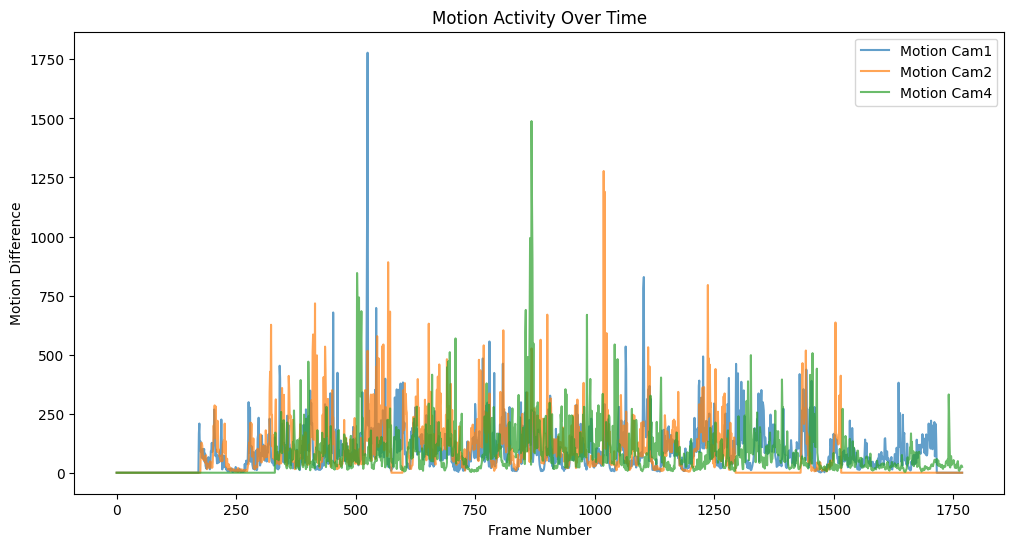

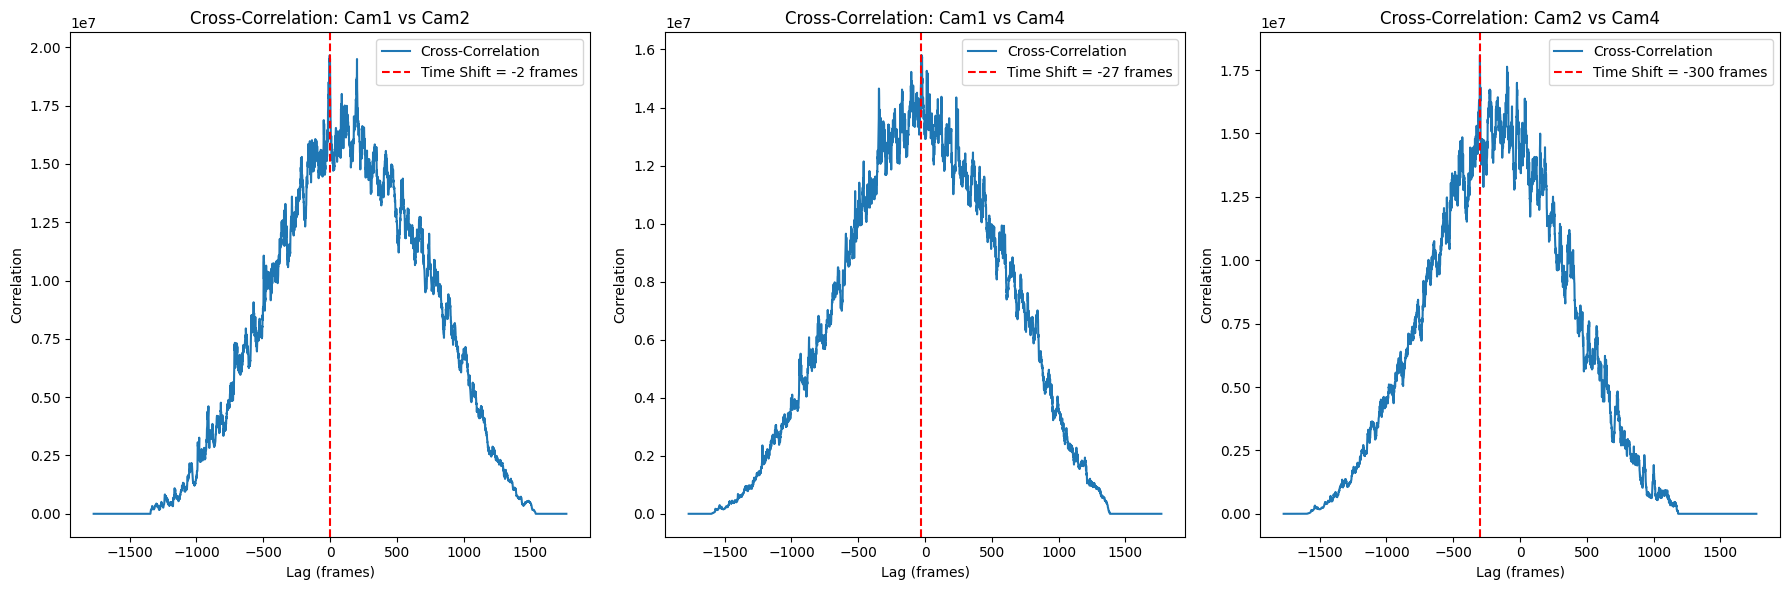

In [ ]:
# Нахождение временных сдвигов между парами камер
time_shift_1_3, correlation_1_3, lags_1_3 = find_time_shift(motion_cam1, motion_cam3)
time_shift_1_4, correlation_1_4, lags_1_4 = find_time_shift(motion_cam1, motion_cam4)
time_shift_3_4, correlation_3_4, lags_3_4 = find_time_shift(motion_cam3, motion_cam4)

# Интерпретация результатов
print("Сравнение cam1 и cam2:")
if time_shift_1_3 > 0:
    print(f"Видео cam2 опережает cam1 на {time_shift_1_3} кадров.")
elif time_shift_1_3 < 0:
    print(f"Видео cam1 опережает cam2 на {-time_shift_1_3} кадров.")
else:
    print("Видео cam1 и cam2 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam1 и cam4:")
if time_shift_1_4 > 0:
    print(f"Видео cam4 опережает cam1 на {time_shift_1_4} кадров.")
elif time_shift_1_4 < 0:
    print(f"Видео cam1 опережает cam4 на {-time_shift_1_4} кадров.")
else:
    print("Видео cam1 и cam4 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam2 и cam4:")
if time_shift_3_4 > 0:
    print(f"Видео cam4 опережает cam2 на {time_shift_3_4} кадров.")
elif time_shift_3_4 < 0:
    print(f"Видео cam2 опережает cam4 на {-time_shift_3_4} кадров.")
else:
    print("Видео cam2 и cam4 синхронизированы (временной сдвиг равен 0).")

# Визуализация частоты движения для всех трех камер
plt.figure(figsize=(12, 6))
plt.plot(motion_cam1, label='Motion Cam1', alpha=0.7)
plt.plot(motion_cam3, label='Motion Cam2', alpha=0.7)
plt.plot(motion_cam4, label='Motion Cam4', alpha=0.7)
plt.title('Motion Activity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Motion Difference')
plt.legend()
plt.show()

# Визуализация перекрестной корреляции для каждой пары камер
plt.figure(figsize=(18, 6))

# Cam1 vs Cam2
plt.subplot(1, 3, 1)
plt.plot(lags_1_3, correlation_1_3, label='Cross-Correlation')
plt.axvline(x=time_shift_1_3, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_3} frames')
plt.title('Cross-Correlation: Cam1 vs Cam2')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam1 vs Cam4
plt.subplot(1, 3, 2)
plt.plot(lags_1_4, correlation_1_4, label='Cross-Correlation')
plt.axvline(x=time_shift_1_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_4} frames')
plt.title('Cross-Correlation: Cam1 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam2 vs Cam4
plt.subplot(1, 3, 3)
plt.plot(lags_3_4, correlation_3_4, label='Cross-Correlation')
plt.axvline(x=time_shift_3_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_3_4} frames')
plt.title('Cross-Correlation: Cam2 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#@title Отрисовываем скелет
def plot_frame(frame_index, offset_cam3, offset_cam4):
    # Получаем данные для выбранного кадра по порядку
    frame_data1 = df1.iloc[frame_index]

    # Применяем сдвиги для третьей и четвертой камер
    shifted_frame_index_cam3 = frame_index + offset_cam3
    shifted_frame_index_cam4 = frame_index + offset_cam4

    # Проверка границ для cam3
    if shifted_frame_index_cam3 < 0 or shifted_frame_index_cam3 >= len(df3):
        print(f"Сдвинутый кадр {shifted_frame_index_cam3} выходит за пределы данных третьей камеры.")
        return

    # Проверка границ для cam4
    if shifted_frame_index_cam4 < 0 or shifted_frame_index_cam4 >= len(df4):
        print(f"Сдвинутый кадр {shifted_frame_index_cam4} выходит за пределы данных четвертой камеры.")
        return

    frame_data3 = df3.iloc[shifted_frame_index_cam3]
    frame_data4 = df4.iloc[shifted_frame_index_cam4]

    # Извлечение координат x и y для всех точек
    def extract_coordinates(frame_data):
        x_coords = []
        y_coords = []
        for col in frame_data.index:
            if col.startswith("x_"):
                x_coords.append(frame_data[col])
            elif col.startswith("y_"):
                y_coords.append(frame_data[col])
        return x_coords, y_coords

    x1, y1 = extract_coordinates(frame_data1)
    x3, y3 = extract_coordinates(frame_data3)
    x4, y4 = extract_coordinates(frame_data4)

    # Определяем максимальные значения по осям X и Y
    max_x = max(max(x1), max(x3), max(x4))
    max_y = max(max(y1), max(y3), max(y4))

    # Создаем фигуру с тремя подграфиками
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # График для cam1
    axes[0].scatter(x1, y1, c='blue', label='cam1')
    axes[0].set_title(f"Camera 1 - Frame Index {frame_index}")
    axes[0].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[0].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[0].grid(True)  # Добавляем сетку
    axes[0].legend()

    # График для cam3
    axes[1].scatter(x3, y3, c='red', label='cam3')
    axes[1].set_title(f"Camera 3 - Frame Index {shifted_frame_index_cam3} (Offset: {offset_cam3})")
    axes[1].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[1].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[1].grid(True)  # Добавляем сетку
    axes[1].legend()

    # График для cam4
    axes[2].scatter(x4, y4, c='green', label='cam4')
    axes[2].set_title(f"Camera 4 - Frame Index {shifted_frame_index_cam4} (Offset: {offset_cam4})")
    axes[2].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[2].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[2].grid(True)  # Добавляем сетку
    axes[2].legend()

    # Функция для рисования связей
    def draw_connections(ax, x_coords, y_coords, connections):
        for start, end in connections:
            if start < len(x_coords) and end < len(x_coords):  # Проверяем, что индексы существуют
                ax.plot([x_coords[start], x_coords[end]], [y_coords[start], y_coords[end]], c='orange')

    # Добавляем связи на графики
    draw_connections(axes[0], x1, y1, connections)
    draw_connections(axes[1], x3, y3, connections)
    draw_connections(axes[2], x4, y4, connections)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

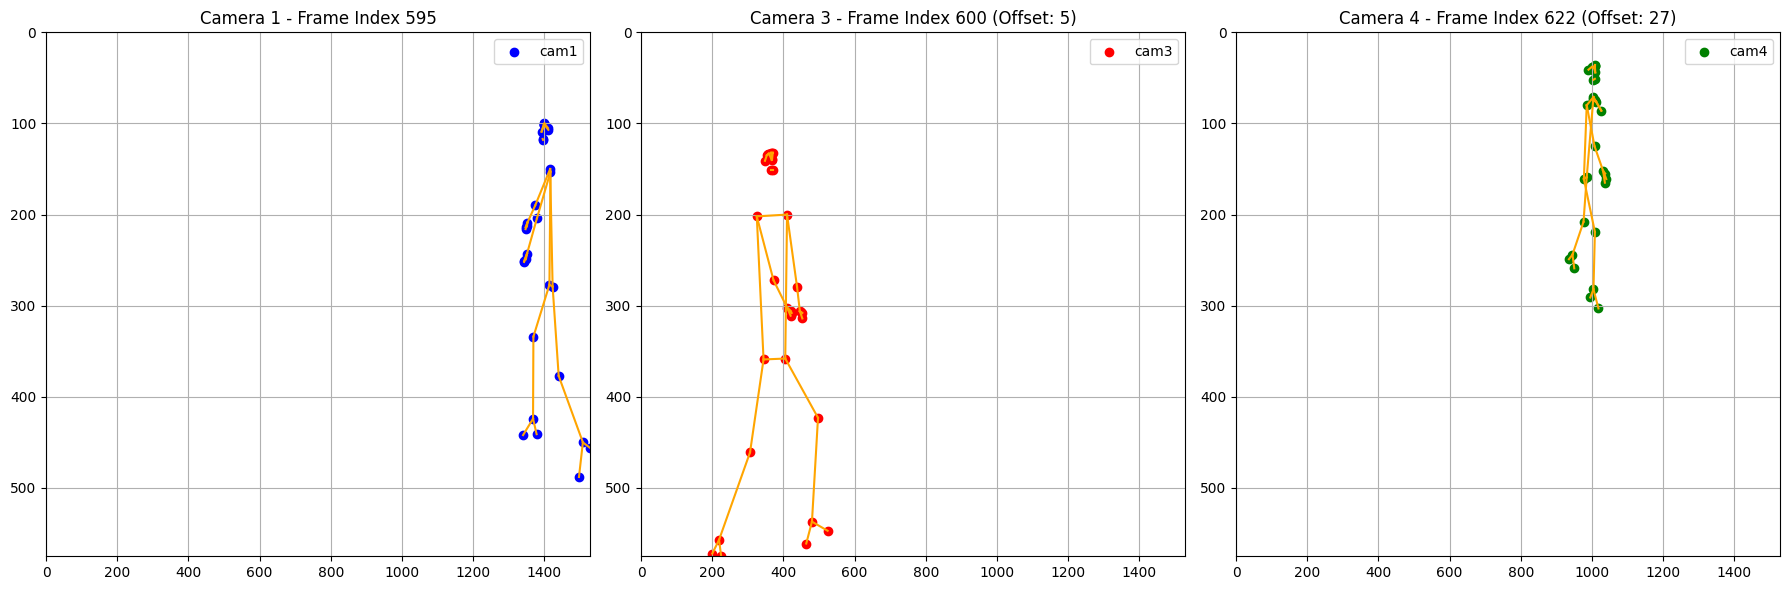

In [ ]:
# Выбираем кадр и сдвиги
frame_index = 595
  # Индекс кадра для cam1
offset_cam4 = 27  # Сдвиг для cam3
offset_cam3 = 5    # Сдвиг для cam4

# Отрисовываем скелеты
plot_frame(frame_index, offset_cam3, offset_cam4)

In [ ]:
#@title Вывод калибровочной конфигурации
import os
import cv2
# Функция для загрузки калибровочных данных
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def load_extrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam}_extrinsics.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внешних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    rotation_matrix = fs.getNode("rotation_matrix").mat()
    translation_vector = fs.getNode("translation_vector").mat()
    fs.release()
    return rotation_matrix, translation_vector

# Загрузка калибровочных данных
calib_dir = '/content/drive/MyDrive/Karate_2/old_video'
cams = ['cam1', 'cam3', 'cam4']

intrinsics = {}
extrinsics = {}

for cam in cams:
    camera_matrix, dist_coeffs = load_intrinsics_opencv(calib_dir, cam)
    rotation_matrix, translation_vector = load_extrinsics_opencv(calib_dir, cam)
    intrinsics[cam] = {'camera_matrix': camera_matrix, 'dist_coeffs': dist_coeffs}
    extrinsics[cam] = {'rotation_matrix': rotation_matrix, 'translation_vector': translation_vector}

In [ ]:
intrinsics

{'cam1': {'camera_matrix': array([[     2513.8,           0,      1313.4],
         [          0,      2490.7,      508.05],
         [          0,           0,           1]]),
  'dist_coeffs': array([[    0.47893,      5.7696,  -0.0058776,    0.040572,     -78.447]])},
 'cam3': {'camera_matrix': array([[     2518.8,           0,      1085.5],
         [          0,      2507.2,      547.67],
         [          0,           0,           1]]),
  'dist_coeffs': array([[     0.2132,    -0.38012,  0.00031123,   0.0047132,     -2.3916]])},
 'cam4': {'camera_matrix': array([[     1334.2,           0,      992.94],
         [          0,      1331.1,       548.9],
         [          0,           0,           1]]),
  'dist_coeffs': array([[  -0.029445,      0.8961,   0.0010754,  -0.0033673,     -2.8553]])}}

In [ ]:
extrinsics

{'cam1': {'rotation_matrix': array([[    0.65264,    -0.75758,    0.011395],
         [   -0.19925,    -0.18612,    -0.96211],
         [      0.731,     0.62565,    -0.27242]]),
  'translation_vector': array([[   -0.22689],
         [     0.3079],
         [     8.6752]])},
 'cam3': {'rotation_matrix': array([[    0.81451,     0.57879,   -0.039633],
         [    0.13008,    -0.24877,    -0.95979],
         [   -0.56538,      0.7766,    -0.27792]]),
  'translation_vector': array([[    -4.0563],
         [   0.049112],
         [     8.4397]])},
 'cam4': {'rotation_matrix': array([[   -0.77413,     0.63297,  -0.0082576],
         [    0.25606,     0.30118,    -0.91855],
         [   -0.57893,    -0.71319,    -0.39523]]),
  'translation_vector': array([[    0.97492],
         [    -2.1655],
         [     9.3899]])}}

In [ ]:
# Функция для создания проекционной матрицы
def create_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    """
    Создает проекционную матрицу P = K[R|t].
    """
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix @ extrinsic_matrix
    return projection_matrix

def synchronize_data(df1, df3, df4, offset_cam3=0, offset_cam4=0):
    """
    Синхронизирует данные трех камер на основе временных сдвигов.
    """
    max_length = min(
        len(df1),
        len(df3) + abs(offset_cam3),
        len(df4) + abs(offset_cam4)
    )

    synchronized_data = {
        'cam1': df1.iloc[:max_length],
        'cam3': df3.iloc[offset_cam3:offset_cam3 + max_length] if offset_cam3 >= 0 else df3.iloc[:len(df3) + offset_cam3],
        'cam4': df4.iloc[offset_cam4:offset_cam4 + max_length] if offset_cam4 >= 0 else df4.iloc[:len(df4) + offset_cam4],
    }
    return synchronized_data

# Взвешенная триангуляция (из triangulation.txt)
def weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files):
    """
    Выполняет взвешенную триангуляцию для получения начальных 3D-координат.
    """
    A = []
    for i in range(len(projection_matrices)):
        P = projection_matrices[i]
        x, y = x_files[i], y_files[i]
        w = likelihood_files[i]  # Вес (достоверность)

        if np.isnan(x) or np.isnan(y) or np.isnan(w) or w == 0:
            continue  # Пропускаем камеры с недоступными данными

        # Уравнения для триангуляции
        A.append(w * (x * P[2] - P[0]))
        A.append(w * (y * P[2] - P[1]))

    if len(A) < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])  # Недостаточно данных для триангуляции

    A = np.array(A)

    # Решение системы уравнений методом SVD
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Последняя строка Vt содержит решение

    # Нормализация однородных координат
    X = X / X[3]

    return X

# Триангуляция для каждой ключевой точки
num_keypoints = 33  # Количество ключевых точек Mediapipe Pose
frames_3d = []

# Синхронизация данных
synchronized_data = synchronize_data(df1, df3, df4, time_shift_1_3, time_shift_1_4)

# Проекционные матрицы
proj_mat1 = create_projection_matrix(intrinsics['cam1']['camera_matrix'], extrinsics['cam1']['rotation_matrix'], extrinsics['cam1']['translation_vector'])
proj_mat3 = create_projection_matrix(intrinsics['cam3']['camera_matrix'], extrinsics['cam3']['rotation_matrix'], extrinsics['cam3']['translation_vector'])
proj_mat4 = create_projection_matrix(intrinsics['cam4']['camera_matrix'], extrinsics['cam4']['rotation_matrix'], extrinsics['cam4']['translation_vector'])

projection_matrices = [proj_mat1, proj_mat3, proj_mat4]

print("Проекционые матрицы")
print(projection_matrices)

# Определение минимальной длины данных
min_length = min(
    len(synchronized_data['cam1']),
    len(synchronized_data['cam3']),
    len(synchronized_data['cam4'])
)

# Обработка только тех кадров, которые доступны для всех камер
for frame_index in range(min_length):
    frame_3d = []
    for keypoint_index in range(num_keypoints):
        # Извлечение координат точки для всех камер
        try:
            x1 = synchronized_data['cam1'].iloc[frame_index][f'x_{keypoint_index}']
            y1 = synchronized_data['cam1'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood1 = synchronized_data['cam1'].iloc[frame_index][f'visibility_{keypoint_index}']

            x3 = synchronized_data['cam3'].iloc[frame_index][f'x_{keypoint_index}']
            y3 = synchronized_data['cam3'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood3 = synchronized_data['cam3'].iloc[frame_index][f'visibility_{keypoint_index}']

            x4 = synchronized_data['cam4'].iloc[frame_index][f'x_{keypoint_index}']
            y4 = synchronized_data['cam4'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood4 = synchronized_data['cam4'].iloc[frame_index][f'visibility_{keypoint_index}']
        except IndexError:
            print(f"Frame index {frame_index} is out of bounds for one of the cameras.")
            continue  # Пропустить текущий кадр

        # Координаты и достоверности
        x_files = [x1, x3, x4]
        y_files = [y1, y3, y4]
        likelihood_files = [likelihood1, likelihood3, likelihood4]

        # Взвешенная триангуляция
        point_3d = weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files)
        frame_3d.append(point_3d[:3])  # Берем только первые три координаты (X, Y, Z)

    frames_3d.append(frame_3d)

# Результат: список 3D-координат для каждого кадра
frames_3d = np.array(frames_3d)

Проекционые матрицы
[array([[     2600.7,     -1082.7,     -329.14,       10823],
       [    -124.89,     -145.72,     -2534.7,      5174.3],
       [      0.731,     0.62565,    -0.27242,      8.6752]]), array([[     1437.9,      2300.8,      -401.5,     -1055.9],
       [     16.488,      -198.4,     -2558.6,      4745.3],
       [   -0.56538,      0.7766,    -0.27792,      8.4397]]), array([[    -1607.7,      136.37,     -403.45,       10624],
       [      23.07,      9.4331,     -1439.6,      2271.5],
       [   -0.57893,    -0.71319,    -0.39523,      9.3899]])]


In [ ]:
frames_3d

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета
def plot_skeleton(frame_index):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return

    # Отображение точек
    x, y, z = valid_keypoints[:, 0], valid_keypoints[:, 1], valid_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(keypoints) and end < len(keypoints) and
                not np.any(np.isnan(keypoints[start])) and not np.any(np.isnan(keypoints[end]))):
            xs = [keypoints[start][0], keypoints[end][0]]
            ys = [keypoints[start][1], keypoints[end][1]]
            zs = [keypoints[start][2], keypoints[end][2]]
            ax.plot(xs, ys, zs, c='blue')

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Ограничение оси X: минимальное значение -10, максимальное — рассчитывается
        ax.set_xlim(-1, 5)
        ax.set_ylim(-1, 5)
        ax.set_zlim(np.min(valid_z), 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    plt.show()

# Создание слайдера для выбора кадра
num_frames = frames_3d.shape[0]  # Общее количество кадров
frame_slider = IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame Index")

# Привязка функции plot_skeleton к слайдеру
interact(plot_skeleton, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame Index', max=1742), Output()), _dom_classes=('widge…

<function __main__.plot_skeleton(frame_index)>

In [ ]:
frames_3d = np.load('/content/drive/MyDrive/Karate_2/old_video/frames_3d-old.npy')

In [ ]:
#@title Отображаем предыдущий скелет, если не найдены точки
import os
import subprocess
import shutil
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import gc

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для генерации кадров
def generate_frames(frames_3d, output_dir, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)

    num_frames = frames_3d.shape[0]  # Общее количество кадров
    print(f"Общее количество кадров: {num_frames}")

    # Переменная для хранения последнего успешно сгенерированного изображения
    last_successful_image = None

    for batch_start in range(0, num_frames, batch_size):
        batch_end = min(batch_start + batch_size, num_frames)
        print(f"Обработка пакета: {batch_start} - {batch_end}")

        # Создание нового графика для каждого пакета
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111, projection='3d')
        plt.ioff()  # Отключаем интерактивный режим

        for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
            # Очистка предыдущего кадра
            ax.clear()

            try:
                # Извлечение координат для выбранного кадра
                keypoints = frames_3d[frame_index]  # (33, 3)

                # Проверка данных
                if np.isnan(keypoints).any() or np.isinf(keypoints).any():
                    raise ValueError(f"Некорректные данные для кадра {frame_index}")

                # Отображение точек
                x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
                ax.scatter(x, y, z, c='red', s=10)

                # Отображение связей между точками
                for start, end in connections:
                    xs = [keypoints[start][0], keypoints[end][0]]
                    ys = [keypoints[start][1], keypoints[end][1]]
                    zs = [keypoints[start][2], keypoints[end][2]]
                    ax.plot(xs, ys, zs, c='blue')

                # Настройка осей на основе данных
                all_x = frames_3d[:, :, 0].flatten()
                all_y = frames_3d[:, :, 1].flatten()
                all_z = frames_3d[:, :, 2].flatten()

                # Исключаем NaN и Inf при расчете пределов осей
                valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
                valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
                valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

                if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
                    ax.set_xlim(-1, 3)
                    ax.set_ylim(-1, 3)
                    ax.set_zlim(0, 2)
                else:
                    raise ValueError("No valid data to set axis limits.")

                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_title(f"Frame {frame_index}")

                # Сохранение кадра
                frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение

                # Сохраняем последнее успешное изображение
                last_successful_image = frame_path

            except Exception as e:
                # Если произошла ошибка, используем последнее успешное изображение
                if last_successful_image:
                    frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
                    shutil.copy(last_successful_image, frame_path)
                    print(f"Использовано предыдущее изображение для кадра {frame_index}: {last_successful_image}")
                else:
                    print(f"Невозможно сгенерировать кадр {frame_index}: {e}")

        # Очистка памяти после обработки пакета
        plt.close(fig)
        gc.collect()

# Функция для изменения размеров изображений
def adjust_image_sizes(output_dir, target_size):
    """
    Изменяет размеры всех изображений в директории до целевого размера.
    :param output_dir: Директория с изображениями.
    :param target_size: Целевой размер (ширина, высота).
    """
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size)
            img_resized.save(img_path)

# Генерация кадров
output_dir = "/content/frames"
generate_frames(frames_3d, output_dir)

# Корректировка размеров изображений
original_width, original_height = plt.gcf().get_size_inches() * plt.gcf().dpi
target_size = (int(original_width // 2 * 2), int(original_height // 2 * 2))  # Размеры, кратные 2
adjust_image_sizes(output_dir, target_size)

print(f"Размеры изображений изменены на {target_size}.")

Общее количество кадров: 1743
Обработка пакета: 0 - 100


Генерация кадров:   8%|▊         | 8/100 [00:00<00:01, 74.50frame/s]

Невозможно сгенерировать кадр 0: Некорректные данные для кадра 0
Невозможно сгенерировать кадр 1: Некорректные данные для кадра 1
Невозможно сгенерировать кадр 2: Некорректные данные для кадра 2
Невозможно сгенерировать кадр 3: Некорректные данные для кадра 3
Невозможно сгенерировать кадр 4: Некорректные данные для кадра 4
Невозможно сгенерировать кадр 5: Некорректные данные для кадра 5
Невозможно сгенерировать кадр 6: Некорректные данные для кадра 6
Невозможно сгенерировать кадр 7: Некорректные данные для кадра 7
Невозможно сгенерировать кадр 8: Некорректные данные для кадра 8
Невозможно сгенерировать кадр 9: Некорректные данные для кадра 9
Невозможно сгенерировать кадр 10: Некорректные данные для кадра 10
Невозможно сгенерировать кадр 11: Некорректные данные для кадра 11
Невозможно сгенерировать кадр 12: Некорректные данные для кадра 12
Невозможно сгенерировать кадр 13: Некорректные данные для кадра 13
Невозможно сгенерировать кадр 14: Некорректные данные для кадра 14
Невозможно сген

Генерация кадров:  31%|███       | 31/100 [00:00<00:00, 98.53frame/s]

Невозможно сгенерировать кадр 18: Некорректные данные для кадра 18
Невозможно сгенерировать кадр 19: Некорректные данные для кадра 19
Невозможно сгенерировать кадр 20: Некорректные данные для кадра 20
Невозможно сгенерировать кадр 21: Некорректные данные для кадра 21
Невозможно сгенерировать кадр 22: Некорректные данные для кадра 22
Невозможно сгенерировать кадр 23: Некорректные данные для кадра 23
Невозможно сгенерировать кадр 24: Некорректные данные для кадра 24
Невозможно сгенерировать кадр 25: Некорректные данные для кадра 25
Невозможно сгенерировать кадр 26: Некорректные данные для кадра 26
Невозможно сгенерировать кадр 27: Некорректные данные для кадра 27
Невозможно сгенерировать кадр 28: Некорректные данные для кадра 28
Невозможно сгенерировать кадр 29: Некорректные данные для кадра 29
Невозможно сгенерировать кадр 30: Некорректные данные для кадра 30
Невозможно сгенерировать кадр 31: Некорректные данные для кадра 31
Невозможно сгенерировать кадр 32: Некорректные данные для кадр

Генерация кадров:  51%|█████     | 51/100 [00:00<00:00, 78.71frame/s]

Невозможно сгенерировать кадр 40: Некорректные данные для кадра 40
Невозможно сгенерировать кадр 41: Некорректные данные для кадра 41
Невозможно сгенерировать кадр 42: Некорректные данные для кадра 42
Невозможно сгенерировать кадр 43: Некорректные данные для кадра 43
Невозможно сгенерировать кадр 44: Некорректные данные для кадра 44
Невозможно сгенерировать кадр 45: Некорректные данные для кадра 45
Невозможно сгенерировать кадр 46: Некорректные данные для кадра 46
Невозможно сгенерировать кадр 47: Некорректные данные для кадра 47
Невозможно сгенерировать кадр 48: Некорректные данные для кадра 48
Невозможно сгенерировать кадр 49: Некорректные данные для кадра 49
Невозможно сгенерировать кадр 50: Некорректные данные для кадра 50
Невозможно сгенерировать кадр 51: Некорректные данные для кадра 51
Невозможно сгенерировать кадр 52: Некорректные данные для кадра 52
Невозможно сгенерировать кадр 53: Некорректные данные для кадра 53
Невозможно сгенерировать кадр 54: Некорректные данные для кадр

Генерация кадров:  74%|███████▍  | 74/100 [00:00<00:00, 95.07frame/s]

Невозможно сгенерировать кадр 55: Некорректные данные для кадра 55
Невозможно сгенерировать кадр 56: Некорректные данные для кадра 56
Невозможно сгенерировать кадр 57: Некорректные данные для кадра 57
Невозможно сгенерировать кадр 58: Некорректные данные для кадра 58
Невозможно сгенерировать кадр 59: Некорректные данные для кадра 59
Невозможно сгенерировать кадр 60: Некорректные данные для кадра 60
Невозможно сгенерировать кадр 61: Некорректные данные для кадра 61
Невозможно сгенерировать кадр 62: Некорректные данные для кадра 62
Невозможно сгенерировать кадр 63: Некорректные данные для кадра 63
Невозможно сгенерировать кадр 64: Некорректные данные для кадра 64
Невозможно сгенерировать кадр 65: Некорректные данные для кадра 65
Невозможно сгенерировать кадр 66: Некорректные данные для кадра 66
Невозможно сгенерировать кадр 67: Некорректные данные для кадра 67
Невозможно сгенерировать кадр 68: Некорректные данные для кадра 68
Невозможно сгенерировать кадр 69: Некорректные данные для кадр

Генерация кадров:  96%|█████████▌| 96/100 [00:01<00:00, 97.19frame/s]

Невозможно сгенерировать кадр 79: Некорректные данные для кадра 79
Невозможно сгенерировать кадр 80: Некорректные данные для кадра 80
Невозможно сгенерировать кадр 81: Некорректные данные для кадра 81
Невозможно сгенерировать кадр 82: Некорректные данные для кадра 82
Невозможно сгенерировать кадр 83: Некорректные данные для кадра 83
Невозможно сгенерировать кадр 84: Некорректные данные для кадра 84
Невозможно сгенерировать кадр 85: Некорректные данные для кадра 85
Невозможно сгенерировать кадр 86: Некорректные данные для кадра 86
Невозможно сгенерировать кадр 87: Некорректные данные для кадра 87
Невозможно сгенерировать кадр 88: Некорректные данные для кадра 88
Невозможно сгенерировать кадр 89: Некорректные данные для кадра 89
Невозможно сгенерировать кадр 90: Некорректные данные для кадра 90
Невозможно сгенерировать кадр 91: Некорректные данные для кадра 91
Невозможно сгенерировать кадр 92: Некорректные данные для кадра 92
Невозможно сгенерировать кадр 93: Некорректные данные для кадр

Генерация кадров: 100%|██████████| 100/100 [00:01<00:00, 93.20frame/s]

Невозможно сгенерировать кадр 99: Некорректные данные для кадра 99


Обработка пакета: 100 - 200


Генерация кадров:   8%|▊         | 8/100 [00:00<00:01, 79.86frame/s]

Невозможно сгенерировать кадр 100: Некорректные данные для кадра 100
Невозможно сгенерировать кадр 101: Некорректные данные для кадра 101
Невозможно сгенерировать кадр 102: Некорректные данные для кадра 102
Невозможно сгенерировать кадр 103: Некорректные данные для кадра 103
Невозможно сгенерировать кадр 104: Некорректные данные для кадра 104
Невозможно сгенерировать кадр 105: Некорректные данные для кадра 105
Невозможно сгенерировать кадр 106: Некорректные данные для кадра 106
Невозможно сгенерировать кадр 107: Некорректные данные для кадра 107
Невозможно сгенерировать кадр 108: Некорректные данные для кадра 108
Невозможно сгенерировать кадр 109: Некорректные данные для кадра 109
Невозможно сгенерировать кадр 110: Некорректные данные для кадра 110
Невозможно сгенерировать кадр 111: Некорректные данные для кадра 111
Невозможно сгенерировать кадр 112: Некорректные данные для кадра 112
Невозможно сгенерировать кадр 113: Некорректные данные для кадра 113
Невозможно сгенерировать кадр 114:

Генерация кадров:  19%|█▉        | 19/100 [00:00<00:00, 88.91frame/s]

Невозможно сгенерировать кадр 119: Некорректные данные для кадра 119
Невозможно сгенерировать кадр 120: Некорректные данные для кадра 120
Невозможно сгенерировать кадр 121: Некорректные данные для кадра 121
Невозможно сгенерировать кадр 122: Некорректные данные для кадра 122
Невозможно сгенерировать кадр 123: Некорректные данные для кадра 123
Невозможно сгенерировать кадр 124: Некорректные данные для кадра 124
Невозможно сгенерировать кадр 125: Некорректные данные для кадра 125
Невозможно сгенерировать кадр 126: Некорректные данные для кадра 126
Невозможно сгенерировать кадр 127: Некорректные данные для кадра 127


Генерация кадров:  29%|██▉       | 29/100 [00:00<00:00, 90.57frame/s]

Невозможно сгенерировать кадр 128: Некорректные данные для кадра 128
Невозможно сгенерировать кадр 129: Некорректные данные для кадра 129
Невозможно сгенерировать кадр 130: Некорректные данные для кадра 130
Невозможно сгенерировать кадр 131: Некорректные данные для кадра 131
Невозможно сгенерировать кадр 132: Некорректные данные для кадра 132
Невозможно сгенерировать кадр 133: Некорректные данные для кадра 133
Невозможно сгенерировать кадр 134: Некорректные данные для кадра 134
Невозможно сгенерировать кадр 135: Некорректные данные для кадра 135


Генерация кадров:  39%|███▉      | 39/100 [00:00<00:00, 90.31frame/s]

Невозможно сгенерировать кадр 136: Некорректные данные для кадра 136
Невозможно сгенерировать кадр 137: Некорректные данные для кадра 137
Невозможно сгенерировать кадр 138: Некорректные данные для кадра 138
Невозможно сгенерировать кадр 139: Некорректные данные для кадра 139
Невозможно сгенерировать кадр 140: Некорректные данные для кадра 140
Невозможно сгенерировать кадр 141: Некорректные данные для кадра 141
Невозможно сгенерировать кадр 142: Некорректные данные для кадра 142
Невозможно сгенерировать кадр 143: Некорректные данные для кадра 143
Невозможно сгенерировать кадр 144: Некорректные данные для кадра 144
Невозможно сгенерировать кадр 145: Некорректные данные для кадра 145
Невозможно сгенерировать кадр 146: Некорректные данные для кадра 146


Генерация кадров:  49%|████▉     | 49/100 [00:00<00:00, 89.82frame/s]

Невозможно сгенерировать кадр 147: Некорректные данные для кадра 147
Невозможно сгенерировать кадр 148: Некорректные данные для кадра 148
Невозможно сгенерировать кадр 149: Некорректные данные для кадра 149
Невозможно сгенерировать кадр 150: Некорректные данные для кадра 150
Невозможно сгенерировать кадр 151: Некорректные данные для кадра 151
Невозможно сгенерировать кадр 152: Некорректные данные для кадра 152
Невозможно сгенерировать кадр 153: Некорректные данные для кадра 153
Невозможно сгенерировать кадр 154: Некорректные данные для кадра 154
Невозможно сгенерировать кадр 155: Некорректные данные для кадра 155
Невозможно сгенерировать кадр 156: Некорректные данные для кадра 156


Генерация кадров:  60%|██████    | 60/100 [00:00<00:00, 95.10frame/s]

Невозможно сгенерировать кадр 157: Некорректные данные для кадра 157
Невозможно сгенерировать кадр 158: Некорректные данные для кадра 158
Невозможно сгенерировать кадр 159: Некорректные данные для кадра 159
Невозможно сгенерировать кадр 160: Некорректные данные для кадра 160
Невозможно сгенерировать кадр 161: Некорректные данные для кадра 161
Невозможно сгенерировать кадр 162: Некорректные данные для кадра 162
Невозможно сгенерировать кадр 163: Некорректные данные для кадра 163
Невозможно сгенерировать кадр 164: Некорректные данные для кадра 164
Невозможно сгенерировать кадр 165: Некорректные данные для кадра 165
Невозможно сгенерировать кадр 166: Некорректные данные для кадра 166
Невозможно сгенерировать кадр 167: Некорректные данные для кадра 167
Невозможно сгенерировать кадр 168: Некорректные данные для кадра 168
Невозможно сгенерировать кадр 169: Некорректные данные для кадра 169


Генерация кадров:  71%|███████   | 71/100 [00:00<00:00, 98.83frame/s]

Невозможно сгенерировать кадр 170: Некорректные данные для кадра 170
Невозможно сгенерировать кадр 171: Некорректные данные для кадра 171
Невозможно сгенерировать кадр 172: Некорректные данные для кадра 172
Невозможно сгенерировать кадр 173: Некорректные данные для кадра 173
Невозможно сгенерировать кадр 174: Некорректные данные для кадра 174


Генерация кадров: 100%|██████████| 100/100 [00:07<00:00, 13.40frame/s]


Обработка пакета: 200 - 300


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.87frame/s]


Обработка пакета: 300 - 400


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.77frame/s]


Обработка пакета: 400 - 500


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.77frame/s]


Обработка пакета: 500 - 600


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.78frame/s]


Обработка пакета: 600 - 700


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.75frame/s]


Обработка пакета: 700 - 800


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.77frame/s]


Обработка пакета: 800 - 900


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.78frame/s]


Обработка пакета: 900 - 1000


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.96frame/s]


Обработка пакета: 1000 - 1100


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.88frame/s]


Обработка пакета: 1100 - 1200


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.78frame/s]


Обработка пакета: 1200 - 1300


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.83frame/s]


Обработка пакета: 1300 - 1400


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.85frame/s]


Обработка пакета: 1400 - 1500


Генерация кадров: 100%|██████████| 100/100 [00:26<00:00,  3.81frame/s]


Обработка пакета: 1500 - 1600


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.91frame/s]


Обработка пакета: 1600 - 1700


Генерация кадров: 100%|██████████| 100/100 [00:25<00:00,  3.94frame/s]


Обработка пакета: 1700 - 1743


Генерация кадров:  84%|████████▎ | 36/43 [00:05<00:00, 31.30frame/s]

Использовано предыдущее изображение для кадра 1716: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1717: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1718: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1719: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1720: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1721: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1722: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1723: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1724: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1725: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1726: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1727: /content/frames/frame_1715.jpg
Испо

Генерация кадров: 100%|██████████| 43/43 [00:05<00:00,  8.10frame/s]


Использовано предыдущее изображение для кадра 1736: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1737: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1738: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1739: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1740: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1741: /content/frames/frame_1715.jpg
Использовано предыдущее изображение для кадра 1742: /content/frames/frame_1715.jpg
Размеры изображений изменены на (800, 400).


In [ ]:
import os
import subprocess

# Убедитесь, что все изображения переименованы в формат frame_%04d.jpg
output_dir = "/content/frames"
for i, filename in enumerate(sorted(os.listdir(output_dir))):
    if filename.endswith(".jpg"):
        new_name = f"frame_{i:04d}.jpg"
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_name))

# Создание видео с помощью FFmpeg
result = subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "-y",  # Перезапись файла
    "/content/output.mp4"
], capture_output=True, text=True)

# Вывод логов
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

print("Видео успешно создано: /content/output.mp4")

STDOUT: 
STDERR: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --ena

In [ ]:
https://drive.google.com/file/d/1mNfFI3siJfIofUrT6GV_U3HG9j-pyBWm/view?usp=sharing